In [1]:
import sys
sys.path.append('../src/')
import importlib
from matplotlib import pylab as plt
%matplotlib inline 

import numpy as np
import torch
import torchvision

import cifar_data
import resnet18
import module2graph
import utils
import dartslike
importlib.reload(utils)
importlib.reload(module2graph)
importlib.reload(dartslike)


<module 'dartslike' from '../src/dartslike.py'>

In [2]:
class LowRankLinear(torch.nn.Module):
    def __init__(self, in_, out_, dim=1):
        super().__init__()
        self.l = torch.nn.Parameter(torch.randn(in_, dim)*1e-3)
        self.r = torch.nn.Parameter(torch.randn(dim, out_) * 1e-3)
    
    def forward(self, x):
        #print (x.shape, self.l.shape, self.r.shape)
        return x@self.l@self.r
    

In [3]:
batch_size = 64
device = 'cpu'  #'cpu'
trial_num = 1
epoch_num = 1
lr = 1e-3
batch_seen = 5

layer_wise = True  # default=False

In [4]:
trainloader, valloader, testloader = cifar_data.get_dataloaders([8,9], batch_size=batch_size, need_val=True)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
model = resnet18.ResNet18(8).to(device)
model.load_state_dict(torch.load('../data/model_last.ckpt', map_location=device))
model.model.fc = torch.nn.Linear(512, 2)
model = module2graph.GraphInterperterWithBernGamma(model, 1.0)

Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
layer_names = list(model.forward(torch.randn(64, 3, 33, 33).to(device), intermediate=True)[1].keys())
sizes = {}
for k,v in model(torch.randn(64, 3, 33, 33).to(device), intermediate=True)[1].items():
    sizes[k] = v.shape
layer_names = [k for k in layer_names if k not in ['flatten', 'x']]
# layer_names = ['model_fc']

In [7]:
class Aux(torch.nn.Module):
    def __init__(self, sizes, layer_names):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        self.layer_names = layer_names
        self.means_int = {}
        self.lsigmas_int = {}
        self.means_y = {}
        self.lsigmas_y = {}
        
        for i in range(len(layer_names)-1):
            current = layer_names[i]
            next_ = layer_names[i+1]
            mat_size = np.prod(sizes[current][1:]) * np.prod(sizes[next_][1:])
            if mat_size>1024*1024:
                linear = LowRankLinear(np.prod(sizes[current][1:]), np.prod(sizes[next_][1:]))
            else:
                linear = torch.nn.Linear(np.prod(sizes[current][1:]), np.prod(sizes[next_][1:]))
            
            lsigma = torch.nn.Parameter(torch.tensor(-2.0))
            self.means_int[current] = linear
            self.lsigmas_int[current] = lsigma
            self.layers.append(linear)
            
        for i in range(len(layer_names)):
            current = layer_names[i]
            linear = torch.nn.Linear(np.prod(sizes[current][1:]), 2)
            lsigma = torch.nn.Parameter(torch.tensor(-2.0))
            self.means_y[current] = linear
            self.lsigmas_y[current] = lsigma
            self.layers.append(linear)
            


In [8]:
for parameter_opt_type in ['MI', 'CE']:
    for gamma_opt_type in ['MI', 'CE']:
        for lam in [0.0, 0.25, 0.5, 0.75, 1.0][::-1]:
            print (parameter_opt_type, gamma_opt_type, lam)

MI MI 1.0
MI MI 0.75
MI MI 0.5
MI MI 0.25
MI MI 0.0
MI CE 1.0
MI CE 0.75
MI CE 0.5
MI CE 0.25
MI CE 0.0
CE MI 1.0
CE MI 0.75
CE MI 0.5
CE MI 0.25
CE MI 0.0
CE CE 1.0
CE CE 0.75
CE CE 0.5
CE CE 0.25
CE CE 0.0


MI.MI.1.0


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
MI.MI.1.0 (tensor(0.8833), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.MI.0.75


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
MI.MI.0.75 (tensor(0.8667), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.MI.0.5


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
MI.MI.0.5 (tensor(0.7333), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.MI.0.25


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
MI.MI.0.25 (tensor(0.8000), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.MI.0.0


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5005000233650208


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.6154999732971191


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.640500009059906


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.628000020980835


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.6134999990463257


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.6050000190734863


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5979999899864197


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.6044999957084656


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5945000052452087


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5929999947547913


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5920000076293945


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5795000195503235


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5764999985694885


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
MI.MI.0.0 (tensor(0.8500), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.1.0


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.492000013589859


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.4779999852180481


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.47099998593330383


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.45649999380111694


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.4514999985694885


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.4494999945163727


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.445499986410141


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.44699999690055847


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.4494999945163727


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.44999998807907104


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.44850000739097595


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.4480000138282776


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.4449999928474426


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
MI.CE.1.0 (tensor(0.8333), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.0.75


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
MI.CE.0.75 (tensor(0.7667), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.0.5


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5040000081062317


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5034999847412109


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.4724999964237213


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.4244999885559082


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.49950000643730164


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
MI.CE.0.5 (tensor(0.8167), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.0.25


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
MI.CE.0.25 (tensor(0.8333), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.0.0


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.4959999918937683


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.40849998593330383


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.3725000023841858


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.3720000088214874


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.37950000166893005


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.3880000114440918


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.3894999921321869


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.38449999690055847


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.3880000114440918


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.38449999690055847


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.38999998569488525


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.390500009059906


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.39149999618530273


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
MI.CE.0.0 (tensor(0.9167), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
CE.MI.1.0


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5715000033378601


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.762499988079071


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.8054999709129333


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.8259999752044678


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.8479999899864197


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.8385000228881836


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.8169999718666077


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.8640000224113464


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.9014999866485596


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.8889999985694885


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.871999979019165


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.8845000267028809


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.8794999718666077


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
CE.MI.1.0 (tensor(0.8167), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
CE.MI.0.75


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.6420000195503235


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.7889999747276306


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.871999979019165


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.8955000042915344


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.8654999732971191


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.765500009059906


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.737500011920929


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.8069999814033508


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.8140000104904175


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.8069999814033508


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.8824999928474426


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.9114999771118164


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.9049999713897705


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
CE.MI.0.75 (tensor(0.9000), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
CE.MI.0.5


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5080000162124634


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.7099999785423279


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.8364999890327454


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.8044999837875366


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.7885000109672546


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.8924999833106995


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.878000020980835


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.8119999766349792


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.777999997138977


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.843500018119812


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.8765000104904175


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.8364999890327454


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
CE.MI.0.5 (tensor(0.8500), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
CE.MI.0.25


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.7580000162124634


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.875


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.8399999737739563


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.8644999861717224


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.8960000276565552


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.8759999871253967


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.8690000176429749


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.8945000171661377


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.9144999980926514


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.906499981880188


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.8514999747276306


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.9014999866485596


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
CE.MI.0.25 (tensor(0.8167), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
CE.MI.0.0


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5005000233650208


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.7459999918937683


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.7820000052452087


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.8619999885559082


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.8784999847412109


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.8694999814033508


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.8849999904632568


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.8420000076293945


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.8424999713897705


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.8615000247955322


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.8634999990463257


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.8330000042915344


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.8889999985694885


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
CE.MI.0.0 (tensor(0.7667), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
CE.CE.0.0


Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5019999742507935


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.675000011920929


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.8725000023841858


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.8615000247955322


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.8840000033378601


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.8769999742507935


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.8784999847412109


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.8834999799728394


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.8989999890327454


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.906499981880188


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.875


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.8999999761581421


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.9045000076293945


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.8790000081062317


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
CE.CE.0.0 (tensor(0.8833), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])


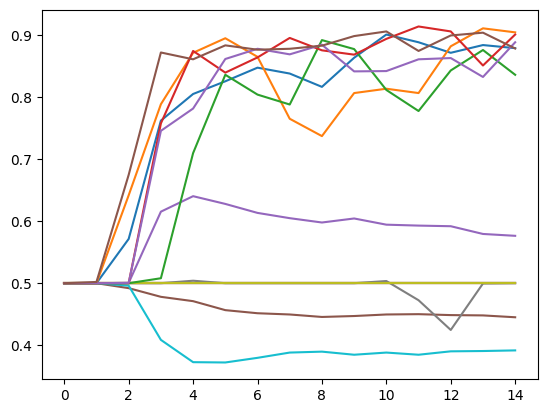

In [9]:
import pickle
import os
import gc
res = {}
for parameter_opt_type in ['MI', 'CE']:
    for gamma_opt_type in ['MI', 'CE']:
        for lam in [0.0, 0.25, 0.5, 0.75, 1.0][::-1]:
            
            if gamma_opt_type == 'CE' and parameter_opt_type == 'CE' and lam != 0.0:
                continue
            name = f'{parameter_opt_type}.{gamma_opt_type}.{lam}'
            print (name)
            if os.path.exists(name+'.pckl'):
                continue
            model = resnet18.ResNet18(8).to(device)
            aux = Aux(sizes, layer_names)
            model.load_state_dict(torch.load('../data/model_last.ckpt', map_location=device))
            model.model.fc = torch.nn.Linear(512, 2)
            model = module2graph.GraphInterperterWithBernGamma(model, 1.0)
            importlib.reload(dartslike)
            dl = dartslike.DartsLikeTrainer(model, parameter_optimization=parameter_opt_type,
                                            gamma_optimization=gamma_opt_type,
                                            aux=aux,
                                            MI_Y_lambda=lam,
                                            layer_wise=layer_wise)
            history = dl.train_loop(trainloader, valloader, testloader, batch_seen, epoch_num, 1e-3, 1e-3, device, 1e-6, )
            
            plt.plot(history, label=lam)
            model.make_gammas_discrete()
            model.discrete = True
            history2 = utils.train_loop(model, trainloader, testloader, batch_seen, epoch_num, lr, device)
            res[name] =  (model.gammas.mean(), history2)
            print (name, res[name])
            with open(name+'.pckl','wb') as out:
                out.write(pickle.dumps( (res[name], history)))
            del model
            del aux
            gc.collect()

MI.MI.1.0 (tensor(0.8833), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.MI.0.75 (tensor(0.8667), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.MI.0.5 (tensor(0.7333), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.MI.0.25 (tensor(0.8000), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.MI.0.0 (tensor(0.8500), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.1.0 (tensor(0.8333), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.0.75 (tensor(0.7667), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.0.5 (tensor(0.8167), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.0.25 (tensor(0.8333), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.0.0 (tensor(0.9167), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.

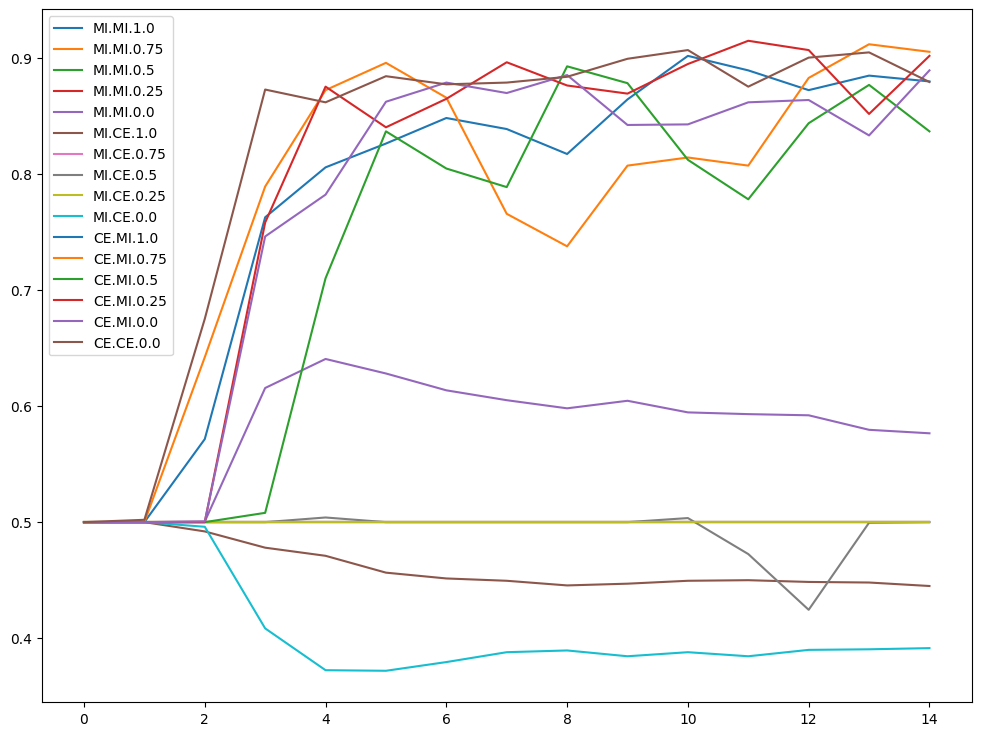

In [17]:
plt.rcParams['figure.figsize'] = (12, 9)
for parameter_opt_type in ['MI', 'CE']:
    for gamma_opt_type in ['MI', 'CE']:
        for lam in [0.0, 0.25, 0.5, 0.75, 1.0][::-1]:
            
            # if parameter_opt_type == 'CE':
            #     continue
            
            if gamma_opt_type == 'CE' and parameter_opt_type == 'CE' and lam != 0.0:
                continue
            name = f'{parameter_opt_type}.{gamma_opt_type}.{lam}'
            with open(name+'.pckl', 'rb') as inp:
                result, history = pickle.loads(inp.read())
                print (name, result)
                plt.plot(history, label=name)
plt.legend(loc='best')